In [11]:
# coding: UTF-8
import argparse
import logging
import os
import random
import sys
from datetime import datetime
from posixpath import join

import faiss
import numpy as np
import pandas as pd
# using labse
# from transformers import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.nn import *

from loader.DBP15KRawNeighbors import DBP15KRawNeighbors
from model.layers_LaBSE_neighbor import Trainer, MyEmbedder
from script.preprocess.deal_raw_dataset import MyRawdataset
from settings import *
import matplotlib.pyplot as plt
sys.argv=['']
del sys
# Labse embedding dim
MAX_LEN = 88

path = '/home1/data5/bowen/code/SelfKG/checkpoints/LaBSE/ja_en/model_neighbor_True_epoch_149_batch_size_96_neg_queue_len_63.ckpt'
def parse_options(parser):
    parser.add_argument('--device', type=str, default='cuda:0')
    parser.add_argument('--time', type=str, default=datetime.now().strftime("%Y%m%d%H%M%S"))
    parser.add_argument('--language', type=str, default='fr_en')
    parser.add_argument('--model_language', type=str, default='fr_en')
    parser.add_argument('--model', type=str, default='LaBSE')

    parser.add_argument('--epoch', type=int, default=300)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--queue_length', type=int, default=64)

    parser.add_argument('--center_norm', type=bool, default=False)
    parser.add_argument('--neighbor_norm', type=bool, default=True)
    parser.add_argument('--emb_norm', type=bool, default=True)
    parser.add_argument('--combine', type=bool, default=True)

    parser.add_argument('--gat_num', type=int, default=1)

    parser.add_argument('--t', type=float, default=0.08)
    parser.add_argument('--momentum', type=float, default=0.9999)
    parser.add_argument('--lr', type=float, default=1e-6)
    parser.add_argument('--dropout', type=float, default=0.3)

    return parser.parse_args()

In [2]:
parser = argparse.ArgumentParser()
args = parse_options(parser)
model = MyEmbedder(args, VOCAB_SIZE)
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
epoch = checkpoint['epoch']

evaluator = Trainer(args, training=False)
evaluator.model = model.cuda()
_1, _2, _3, _4, _5, fail_ids2_at10 = evaluator.evaluate(149)

17it [00:00, 162.98it/s]

Evaluate at epoch 149...


308it [00:01, 182.58it/s]
313it [00:01, 193.34it/s]


========Validation========
#Entity: 225
Hit@1: 0.916
Hit@10:0.982
===========Test===========
#Entity: 10500
Hit@1: 0.947
Hit@10:0.99


In [3]:
link = evaluator.link

In [4]:
from loader.DBP15kRawLoader import DBP15kRawLoader, ENDBP15kRawLoader

id_entity_1 = DBP15kRawLoader(language="fr_en").id_entity
id_entity_2 = ENDBP15kRawLoader(language="fr_en").id_entity

In [5]:
id_neighbors_dict1 = {}
filepath = '/home1/data5/bowen/code/SelfKG/data/DBP15K/fr_en/triples_1'
data = pd.read_csv(filepath, header=None, sep='\t')
data.columns = ['head', 'relation', 'tail']

for index, row in data.iterrows():
    head_str = id_entity_1[int(row['head'])]
    tail_str = id_entity_1[int(row['tail'])]
    # print(head_str)
    if not id_entity_1[int(row['head'])] in id_neighbors_dict1.keys():
        id_neighbors_dict1[id_entity_1[int(row['head'])]] = [head_str]
    if not tail_str in id_neighbors_dict1[id_entity_1[int(row['head'])]]:
        id_neighbors_dict1[id_entity_1[int(row['head'])]].append(tail_str)
    
    if not id_entity_1[int(row['tail'])] in id_neighbors_dict1.keys():
        id_neighbors_dict1[id_entity_1[int(row['tail'])]] = [tail_str]
    if not head_str in id_neighbors_dict1[id_entity_1[int(row['tail'])]]:
        id_neighbors_dict1[id_entity_1[int(row['tail'])]].append(head_str)

In [6]:
id_neighbors_dict2 = {}
filepath = '/home1/data5/bowen/code/SelfKG/data/DBP15K/fr_en/triples_2'
data = pd.read_csv(filepath, header=None, sep='\t')
data.columns = ['head', 'relation', 'tail']

for index, row in data.iterrows():
    head_str = id_entity_2[int(row['head'])]
    tail_str = id_entity_2[int(row['tail'])]
    # print(head_str)
    if not id_entity_2[int(row['head'])] in id_neighbors_dict2.keys():
        id_neighbors_dict2[id_entity_2[int(row['head'])]] = [head_str]
    if not tail_str in id_neighbors_dict2[id_entity_2[int(row['head'])]]:
        id_neighbors_dict2[id_entity_2[int(row['head'])]].append(tail_str)
    
    if not id_entity_2[int(row['tail'])] in id_neighbors_dict2.keys():
        id_neighbors_dict2[id_entity_2[int(row['tail'])]] = [tail_str]
    if not head_str in id_neighbors_dict2[id_entity_2[int(row['tail'])]]:
        id_neighbors_dict2[id_entity_2[int(row['tail'])]].append(head_str)

In [20]:
list_at1 = []
_num = []
for _id2 in fail_ids2_at10:
    _id1 = link[_id2]
    tempdict = {}
    tempdict['fr_entity'] = id_entity_1[_id1]
    tempdict['fr_entity_neighbors'] = id_neighbors_dict1[id_entity_1[_id1]][1:]
    tempdict['fr_entity_num'] = str(len(id_neighbors_dict1[id_entity_1[_id1]])-1)
    tempdict['en_entity'] = id_entity_2[_id2]
    tempdict['en_entity_neighbors'] = id_neighbors_dict2[id_entity_2[_id2]][1:]
    tempdict['en_entity_num'] = str(len(id_neighbors_dict2[id_entity_2[_id2]])-1)
    _num.append([len(id_neighbors_dict1[id_entity_1[_id1]])-1, len(id_neighbors_dict2[id_entity_2[_id2]])-1])

    # tempdict['fr_entity'] = id_entity_1[_id1].strip('\n')
    # tempdict['fr_entity_neighbors'] = [item.strip('\n') for item in id_neighbors_dict1[id_entity_1[_id1]]]
    # tempdict['en_entity'] = id_entity_2[_id2].strip('\n')
    # tempdict['en_entity_neighbors'] = [item.strip('\n') for item in id_neighbors_dict2[id_entity_2[_id2]]]
    
    list_at1.append(tempdict)

In [8]:
import json
with open(FAIL_DIR + '/fr_failed_hit10','w', encoding='utf-8') as f:
    for my_dict in list_at1:
        for item in my_dict.items():
            json.dump(item, f, ensure_ascii=False)
            f.write('\n')
            if item[0] == 'en_entity_num':
                f.write('\n')

In [29]:
import pickle
 
f = open('fr_num.pckl', 'wb')
pickle.dump(_num, f)
f.close()

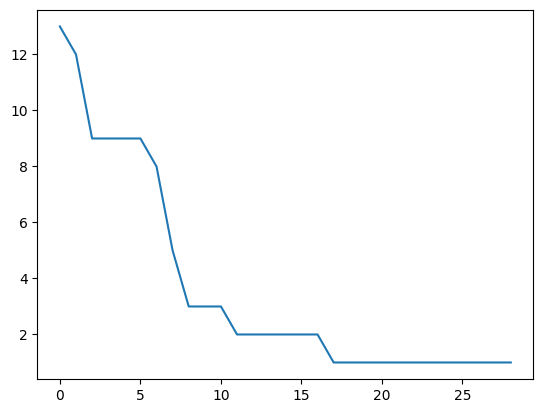

In [28]:
import collections


result = collections.Counter(np.array(_num)[:,0])
# _num[:,1]
# print(np.array(_num)[:,0])
# print(result)
x = np.arange(0, len(result))
y = list(result.values())
y.sort(reverse=True)
plt.plot(x,y)


In [ ]:
fig = plt.figure()
#选择图纸1
ax1=plt.subplot(1,2,1) 
plt.yscale('log')
plt.plot(src_ent_x, src_ent_y, color='red',label='src-ent')
plt.plot(tgt_ent_x, tgt_ent_y, color='blue',label='tgt-ent')
# plt.axis([0, 100000, 0, 2000])
plt.xlabel('Entity Num')
plt.ylabel('Edge Num (log)')
plt.legend(loc = 'best')
plt.title('Long Tail Statistics of Entity')
plt.grid()